In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import deque
import gym
from gym.wrappers.monitoring.video_recorder import VideoRecorder
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# Define the Deep Q-Network (DQN) architecture
class DQN(nn.Module):
    def __init__(self, input_size, output_size, num_hidden=32):
        super(DQN, self).__init__()

        self.network  = torch.nn.Sequential(
            nn.Linear(input_size, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, output_size)
        )

    def forward(self, x):
        return self.network(x)

In [ ]:
# Define the Experience Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)

    def push(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

In [ ]:
# Initialize the environment and the DQN
env_id = "CartPole-v1"
env = gym.make(env_id, render_mode='rgb_array')
input_size = env.observation_space.shape[0]
output_size = env.action_space.n
dqn = DQN(input_size, output_size)

# Define hyperparameters
batch_size = 32
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.01
replay_buffer = ReplayBuffer(capacity=10000)
optimizer = optim.Adam(dqn.parameters(), lr=0.003)
loss_fn = nn.SmoothL1Loss()

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


## Deep Q-Network with replay buffer

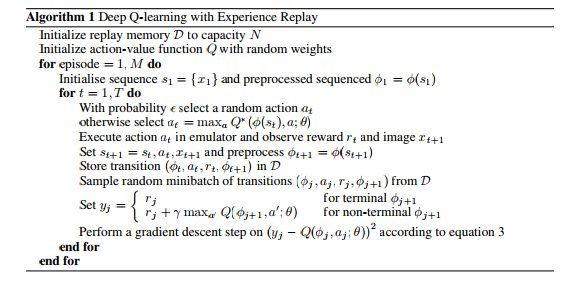

In [ ]:
# Training loop
def DQN_train(num_episodes=1000, epsilon = 0.1):
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            # Epsilon-greedy action selection
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                q_values = dqn(state_tensor)
                action = torch.argmax(q_values).item()

            next_state, reward, done, _ = env.step(action)
            total_reward += reward

            # Store the transition in the replay buffer
            replay_buffer.push((state, action, reward, next_state, done))

            state = next_state

            # Sample a random minibatch from the replay buffer and update the DQN
            if len(replay_buffer.buffer) >= batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

                state_tensors = torch.tensor(states, dtype=torch.float32)
                action_tensors = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
                reward_tensors = torch.tensor(rewards, dtype=torch.float32)
                next_state_tensors = torch.tensor(next_states, dtype=torch.float32)
                done_tensors = torch.tensor(dones, dtype=torch.float32)

                q_values = dqn(state_tensors).gather(1, action_tensors)
                next_q_values = dqn(next_state_tensors).max(1)[0].detach()
                target_q_values = reward_tensors + gamma * next_q_values * (1 - done_tensors)

                loss = loss_fn(q_values, target_q_values.unsqueeze(1))

                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(dqn.parameters(), max_norm=1)  # Gradient clipping
                optimizer.step()

        # Decay epsilon to reduce exploration over time
        epsilon = max(epsilon * epsilon_decay, epsilon_min)

        if episode % 100 == 0:
            print(f"Episode {episode}, Total reward: {total_reward}")

DQN_train(num_episodes=1000, epsilon=epsilon)

Episode 0, Total reward: 14.0
Episode 100, Total reward: 11.0
Episode 200, Total reward: 9.0
Episode 300, Total reward: 12.0
Episode 400, Total reward: 10.0
Episode 500, Total reward: 11.0
Episode 600, Total reward: 9.0
Episode 700, Total reward: 8.0
Episode 800, Total reward: 10.0


KeyboardInterrupt: ignored

## Evaluation

In [ ]:
def evaluate_model(dqn, env, num_episodes=10):
    total_rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        episode_reward = 0

        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            q_values = dqn(state_tensor)
            action = torch.argmax(q_values).item()

            next_state, reward, done, _ = env.step(action)
            episode_reward += reward
            state = next_state

        total_rewards.append(episode_reward)


    average_reward = sum(total_rewards) / num_episodes
    print(f"Average reward over {num_episodes} episodes: {average_reward}")
    return average_reward

In [ ]:
evaluate_model(dqn, env, num_episodes=10)

## Deep Q-Network with Taget Network

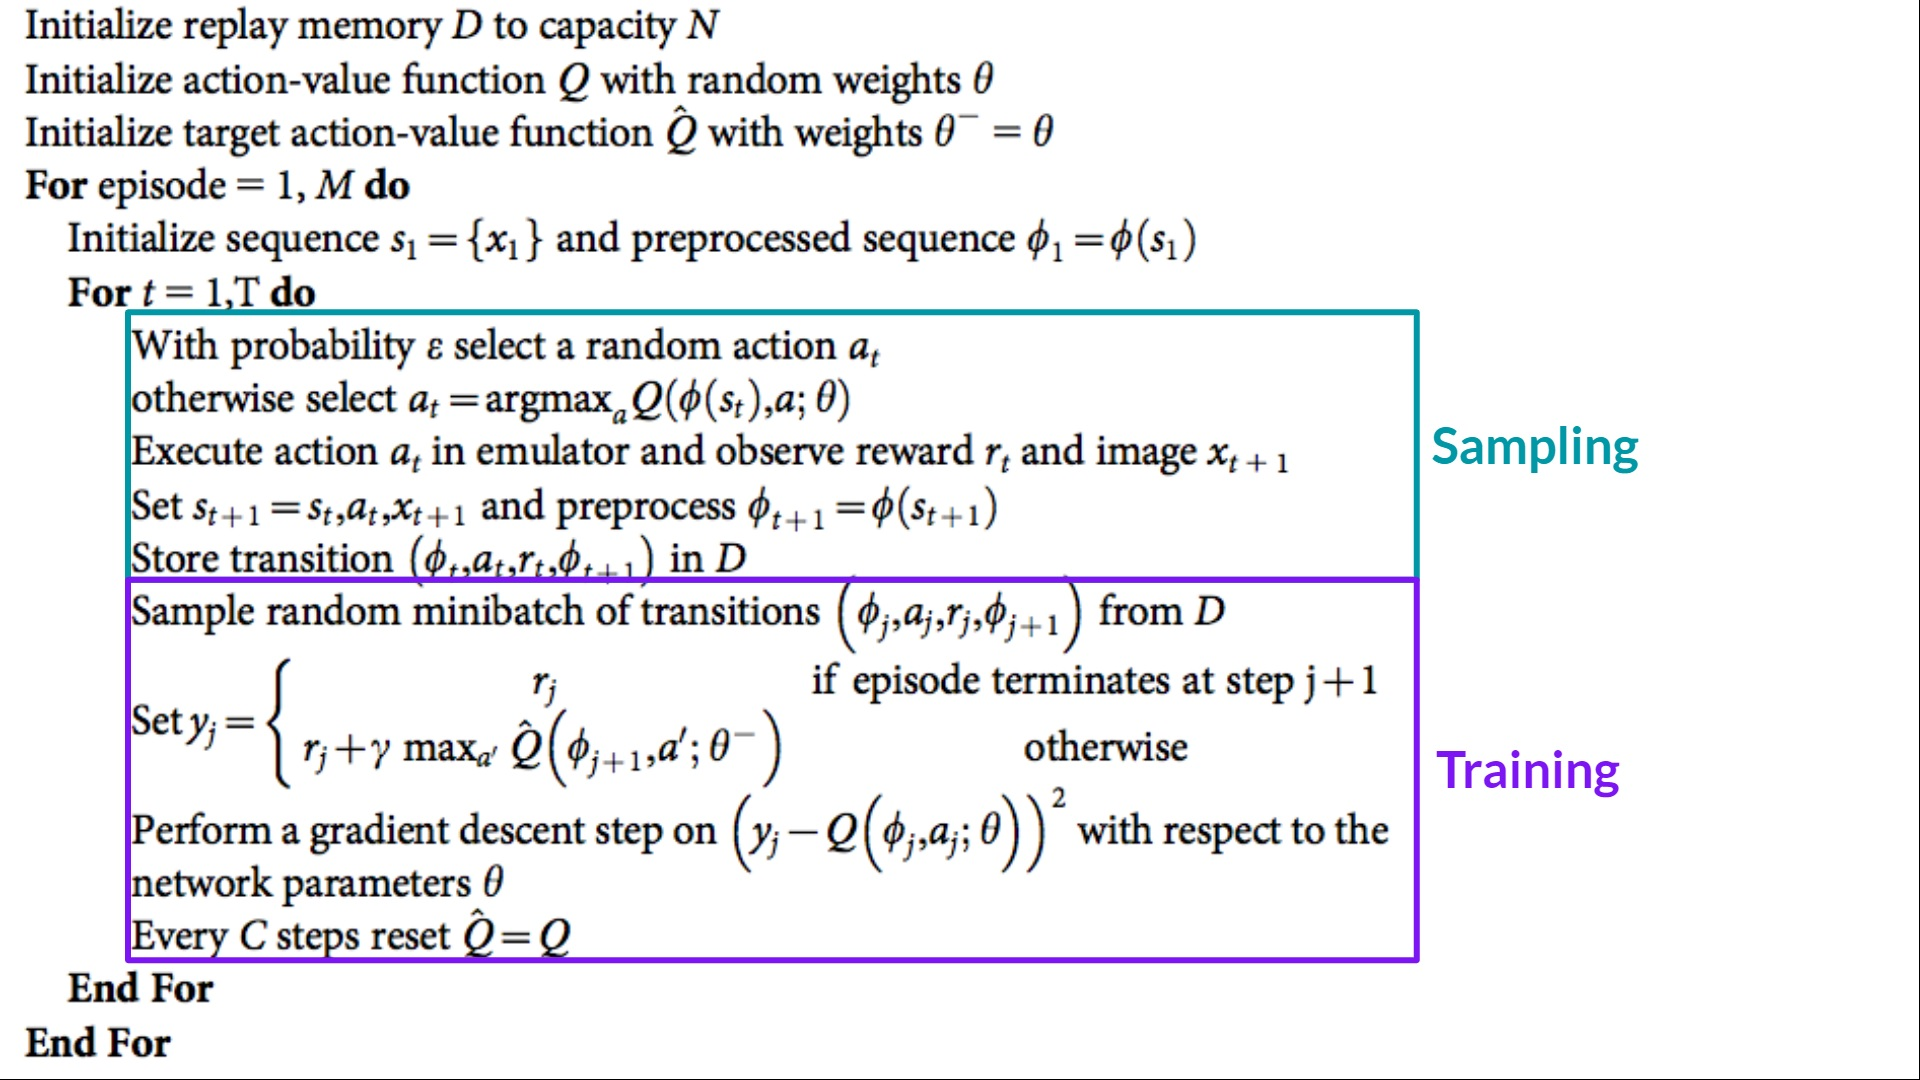

In [ ]:
# Initialize the environment and the DQN
env_id = 'CartPole-v1'
env = gym.make(env_id, render_mode='rgb_array')
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

num_hidden = 64
dqn_online = DQN(input_size, output_size, num_hidden)
dqn_target = DQN(input_size, output_size, num_hidden)
dqn_target.load_state_dict(dqn_online.state_dict())
target_update_interval = 10
tau = 0.01  # Update rate for the target network

# Define hyperparameters
batch_size = 64
gamma = 0.99
epsilon = 0.1
epsilon_decay = 0.995
epsilon_min = 0.01

replay_buffer = ReplayBuffer(capacity=10000)
optimizer = optim.Adam(dqn_online.parameters(), lr=1e-3)
loss_fn = nn.SmoothL1Loss()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
# Soft update of target network
def soft_update(target, online, tau):
    for target_param, online_param in zip(target.parameters(), online.parameters()):
        target_param.data.copy_(tau * online_param.data + (1.0 - tau) * target_param.data)

Episode 0, Total reward: 11.0
Episode 100, Total reward: 10.0
Episode 200, Total reward: 10.0
Episode 300, Total reward: 8.0
Episode 400, Total reward: 9.0
Episode 500, Total reward: 9.0
Episode 600, Total reward: 10.0
Episode 700, Total reward: 9.0
Episode 800, Total reward: 10.0
Episode 900, Total reward: 10.0
Episode 1000, Total reward: 13.0
Episode 1100, Total reward: 10.0
Episode 1200, Total reward: 15.0
Episode 1300, Total reward: 22.0
Episode 1400, Total reward: 14.0
Episode 1500, Total reward: 19.0
Episode 1600, Total reward: 22.0
Episode 1700, Total reward: 21.0
Episode 1800, Total reward: 19.0
Episode 1900, Total reward: 21.0
Episode 2000, Total reward: 17.0
Episode 2100, Total reward: 20.0
Episode 2200, Total reward: 22.0
Episode 2300, Total reward: 23.0
Episode 2400, Total reward: 25.0
Episode 2500, Total reward: 22.0
Episode 2600, Total reward: 19.0
Episode 2700, Total reward: 117.0
Episode 2800, Total reward: 15.0
Episode 2900, Total reward: 39.0
Episode 3000, Total rewar

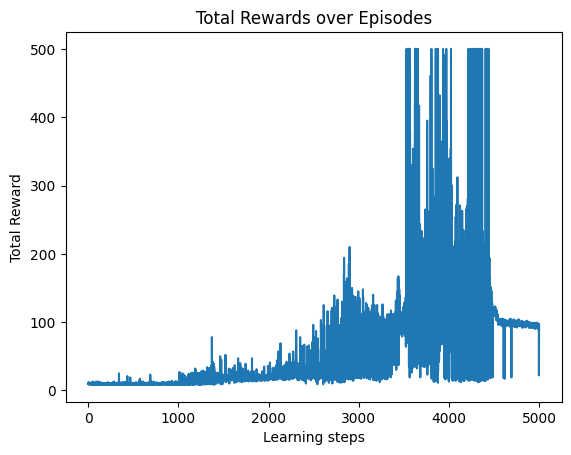

In [ ]:
# Training loop
def DQN_with_target_train(num_episodes=1000, epsilon=0.1):
    total_rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            # Epsilon-greedy action selection
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                q_values = dqn_online(state_tensor)
                action = torch.argmax(q_values).item()

            next_state, reward, done, _ = env.step(action)
            total_reward += reward

            # Store the transition in the replay buffer
            replay_buffer.push((state, action, reward, next_state, done))

            state = next_state

            # Sample a random minibatch from the replay buffer and update the DQN
            if len(replay_buffer.buffer) >= batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

                state_tensors = torch.tensor(states, dtype=torch.float32)
                action_tensors = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
                reward_tensors = torch.tensor(rewards, dtype=torch.float32)
                next_state_tensors = torch.tensor(next_states, dtype=torch.float32)
                done_tensors = torch.tensor(dones, dtype=torch.float32)

                q_values = dqn_online(state_tensors).gather(1, action_tensors)
                next_q_values = dqn_target(next_state_tensors).max(1)[0].detach()
                target_q_values = reward_tensors + gamma * next_q_values * (1 - done_tensors)

                loss = loss_fn(q_values, target_q_values.unsqueeze(1))

                optimizer.zero_grad()
                loss.backward()
                # nn.utils.clip_grad_norm_(dqn_online.parameters(), max_norm=1)  # Gradient clipping
                optimizer.step()

        # Decay epsilon to reduce exploration over time
        epsilon = max(epsilon * epsilon_decay, epsilon_min)

        if episode % target_update_interval == 0:
            soft_update(dqn_target, dqn_online, tau)

        if episode % 100 == 0:
            print(f"Episode {episode}, Total reward: {total_reward}")

        total_rewards.append(total_reward)

    # Show the plot of total rewards during learning steps
    plt.plot(total_rewards)
    plt.xlabel('Learning steps')
    plt.ylabel('Total Reward')
    plt.title('Total Rewards over Episodes')
    plt.show()

DQN_with_target_train(num_episodes=5000, epsilon=epsilon)

In [ ]:
evaluate_model(dqn_online, env, num_episodes=10)

Average reward over 10 episodes: 93.1


93.1

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=False, size=(1400, 900))
_ = display.start()

video_path = f"./video/{env_id}.mp4"
video_recorder = VideoRecorder(env, video_path, enabled=True)

def record_video(dqn, env):
    state = env.reset()
    done = False

    while not done:
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        q_values = dqn(state_tensor)
        action = torch.argmax(q_values).item()
        next_state, reward, done, _ = env.step(action)
        state = next_state

        video_recorder.capture_frame()

    video_recorder.close()

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


In [ ]:
record_video(dqn_online, env)

In [ ]:
from base64 import b64encode

def render_mp4(videopath: str) -> str:
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

In [ ]:
from IPython.display import HTML

html = render_mp4(video_path)
HTML(html)